Long Short Term Mermory network（LSTM）

Long Short Term Mermory network（LSTM）是一种特殊的RNNs，可以很好地解决长时依赖问题。

理解LSTMs的关键就是memory block（记忆块），主要包含了三个门（forget gate、input gate、output gate）与一个记忆单元（cell）。方框内上方的那条水平线，被称为cell state（单元状态），它就像一个传送带，可以控制信息传递给下一时刻。

$f_t=\sigma (w_f \cdot [h_{t-1} ,x_t] +b_f  ) $

$i_t=\sigma (w_i \cdot [h_{t-1} ,x_t] +b_i) $

$\widetilde{C_t}=tanh( w_c \cdot [h_{t-1} ,x_t] +b_c) $

$ C_t=f_t * C_{t-1} + i_t * \widetilde{C_t} $

$o_t=\sigma (w_o \cdot [h_{t-1} ,x_t] +b_o) $

$h_t= o_t * tanh(C_t)$


In [7]:
import tensorflow as tf

model = tf.keras.model.Sequential(
    tf.keras.layers.Embedding(1000, 128),
    tf.keras.layers.LSTM(units=64),
    tf.keras.layers.Dense(10)
)
model.summary()

AttributeError: module 'keras.api._v2.keras' has no attribute 'model'

In [ ]:
# 支持多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #默认为'last'

In [ ]:
# 导入常用的包
import numpy as np
from torch import nn,optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

In [ ]:
# 载入数据
train_dataset = datasets.MNIST(root = './data2/', # 载入的数据存放的位置
                               train = True, # 载入训练集数据
                               transform = transforms.ToTensor(), # 将载入进来的数据变成Tensor
                               download = True) # 是否下载数据
test_dataset = datasets.MNIST(root = './data2/', # 载入的数据存放的位置
                               train = False, # 载入测试集数据
                               transform = transforms.ToTensor(), # 将载入进来的数据变成Tensor
                               download = True) # 是否下载数据

9913344it [00:03, 2495600.00it/s]                             


Extracting ./data2/MNIST\raw\train-images-idx3-ubyte.gz to ./data2/MNIST\raw



29696it [00:00, 4253749.93it/s]          


Extracting ./data2/MNIST\raw\train-labels-idx1-ubyte.gz to ./data2/MNIST\raw



1649664it [00:01, 924636.32it/s]                              


Extracting ./data2/MNIST\raw\t10k-images-idx3-ubyte.gz to ./data2/MNIST\raw



5120it [00:00, ?it/s]                   

Extracting ./data2/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data2/MNIST\raw




d:\anaconda\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# 批次大小
batch_size = 64

# 装载训练集
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True)

# 装载训练集
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

In [ ]:
# 定义网络结构
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        # 定义LSTM层(相当于隐藏层)
        # input_size 表示数据输入特征的大小
        # hidden_size 表示LSTM模块的数量
        # num_layers 表示隐藏层的层数, 一般设置1-3层就可以了
        # batch_first 用于设置数据格式，默认：input(seq_len, batch, feature)
        # 当batch_first = True，则input和output数据的格式变为：(batch, seq_len, feature)
        self.lstm = torch.nn.LSTM(
            input_size = 28,
            hidden_size = 64,
            num_layers = 1,
            batch_first = True
        )
        # 定义全连接层
        # 这里的in_features=64，是因为LSTM层中hidden_size = 64，每一个LSTM块都会输出一个值.
        self.out = torch.nn.Linear(in_features=64, out_features=10)
        # softmax
        self.softmax = torch.nn.Softmax(dim = 1)
        
        
    def forward(self, x):
        # 我们要将数据reshape成3维数据(batch, seq_len, feature)
        # seq_len表示序列长度
        # feature：表示每次传入数据的个数
        x = x.view(-1, 28, 28)
        # output: 包含每个批次的每个序列的每个LSTM单元的输出结果,是3维[batch, seq_len, hidden_size]
        # 虽然LSTM的batch_first = True，但是h_n和c_n的第一个维度还是seq_len
        # h_n: [num_layers, batch, hidden_size] 只包含最后一个序列的输出结果
        # c_n: [num_layers, batch, hidden_size] 只包含最后一个序列的输出结果
        output, (h_n, c_n) = self.lstm(x)
        # 如果这里有很多隐藏层，那么我们只需要最后一层的输出结果
        output_in_last_timestep = h_n[-1, :, :]
        x = self.out(output_in_last_timestep)
        x = self.softmax(x)
        return x

In [ ]:
LR = 0.0003
# 定义模型
model = LSTM()
# 定义代价函数为交叉熵代价函数
mse_loss = nn.CrossEntropyLoss()
# 定义优化器Adam
optimizer = optim.Adam(model.parameters(), LR)

In [ ]:
def train():
    model.train()
    for i,data in enumerate(train_loader):
        # 获得一个批次的数据和标签
        inputs, labels = data
        # 获得模型预测结果（64,10）
        out = model(inputs)
        # 计算loss,交叉熵代价函数out(batch,C), labels(batch)
        loss = mse_loss(out, labels)
        # 梯度清0
        optimizer.zero_grad()
        # 计算梯度
        loss.backward()
        # 修改权值
        optimizer.step()

def test():
    model.eval()
    
    # 计算训练集准确率
    correct = 0
    for i,data in enumerate(train_loader):
        # 获得一个批次的数据和标签
        inputs, labels = data
        # 获得模型预测结果（64,10）
        out = model(inputs)
        # 获得最大值，以及最大值所在的位置
        _, predicted = torch.max(out, 1)
        # 预测正确的数量
        correct += (predicted == labels).sum()
    print("Train acc:{0}".format(correct.item()/len(train_dataset)))
    
    # 计算测试集准确率
    correct = 0
    for i,data in enumerate(test_loader):
        # 获得一个批次的数据和标签
        inputs, labels = data
        # 获得模型预测结果（64,10）
        out = model(inputs)
        # 获得最大值，以及最大值所在的位置
        _, predicted = torch.max(out, 1)
        # 预测正确的数量
        correct += (predicted == labels).sum()
    print("Test acc:{0}".format(correct.item()/len(test_dataset)))

In [ ]:
for epoch in range(5):
    print('epoch:',epoch)
    train()
    test()

epoch: 0
Train acc:0.78
Test acc:0.7796
epoch: 1
Train acc:0.83265
Test acc:0.8359
epoch: 2
Train acc:0.84785
Test acc:0.8491
epoch: 3
Train acc:0.9138
Test acc:0.917
epoch: 4
Train acc:0.9365
Test acc:0.9355


![图片](E:\坚果云\精益求精\warmup\RNNLSTMGRU\lstm.PNG)

In [ ]:
torch.save(model.state_dict(), "./my_model.pth")

In [ ]:
model_new = LSTM()
# 载入模型
model_new.load_state_dict(torch.load("./my_model.pth"))

<All keys matched successfully>

In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
 
 
# 加载数据集
def parser(x):
    return datetime.strptime(x, '%Y/%m/%d')
 
 
# 将时间序列转换为监督类型的数据序列
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # 这个for循环是用来输入列标题的 var1(t-1)，var1(t)，var1(t+1)，var1(t+2)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 转换为监督型数据的预测序列 每四个一组，对应 var1(t-1)，var1(t)，var1(t+1)，var1(t+2)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # 拼接数据
    agg = concat(cols, axis=1)
    agg.columns = names
    # 把null值转换为0
    if dropnan:
        agg.dropna(inplace=True)
    print(agg)
    return agg
 
 
# 对传入的数列做差分操作，相邻两值相减
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
 
# 将序列转换为用于监督学习的训练和测试集
def prepare_data(series, n_test, n_lag, n_seq):
    # 提取原始值
    raw_values = series.values
    # 将数据转换为静态的
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # 重新调整数据为（-1,1）之间
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # 转化为有监督的数据X，y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # 分割为测试数据和训练数据
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test
 
 
# 匹配LSTM网络训练数据
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # 重塑训练数据格式 [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # 配置一个LSTM神经网络，添加网络参数
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # 调用网络，迭代数据对神经网络进行训练，最后输出训练好的网络模型
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
 
# 用LSTM做预测
def forecast_lstm(model, X, n_batch):
    # 重构输入参数 [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # 开始预测
    forecast = model.predict(X, batch_size=n_batch)
    # 结果转换成数组
    return [x for x in forecast[0, :]]
 
 
# 利用训练好的网络模型，对测试数据进行预测
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    # 预测方式是用一个X值预测出后三步的Y值
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # 调用训练好的模型预测未来数据
        forecast = forecast_lstm(model, X, n_batch)
        # 将预测的数据保存
        forecasts.append(forecast)
    return forecasts
 
 
# 对预测后的缩放值（-1，1）进行逆变换
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i - 1])
    return inverted
 
 
# 对预测完成的数据进行逆变换
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # 将预测后的数据缩放逆转换
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        # 将预测后的数据差值逆转换
        inv_diff = inverse_difference(last_ob, inv_scale)
        # 保存数据
        inverted.append(inv_diff)
    return inverted
 
 
# 评估每个预测时间步的RMSE
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i + 1), rmse))
 
 
# 在原始数据集的上下文中绘制预测图
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    pyplot.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        pyplot.plot(xaxis, yaxis, color='red')
    # show the plot
    pyplot.show()
 
 
# 加载数据
series = read_csv('./shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# 配置网络信息
n_lag = 1
n_seq = 3
n_test = 10
n_epochs = 1500
n_batch = 1
n_neurons = 1
# 准备数据
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
# 准备预测模型
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# 开始预测
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# 逆转换训练数据和预测数据
forecasts = inverse_transform(series, forecasts, scaler, n_test + 2)
# 逆转换测试数据
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test + 2)
# 比较预测数据和测试数据，计算两者之间的损失值
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# 画图
plot_forecasts(series, forecasts, n_test + 2)

In [ ]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('./raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [ ]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

<Figure size 432x288 with 0 Axes>

: 

: 

In [ ]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

NameError: name 'reframed' is not defined

In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

NameError: name 'reframed' is not defined

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

NameError: name 'Sequential' is not defined

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

NameError: name 'model' is not defined

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  
(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)
Epoch 1/50
122/122 - 9s - loss: 0.0588 - val_loss: 0.0507 - 9s/epoch - 75ms/step
Epoch 2/50
122/122 - 2s - loss: 0.0395 - val_loss: 0.0463 - 2s/epoch - 14ms/step
Epoch 3/50
122/122 - 2s - loss: 0.0207 - val_loss: 0.0368 - 2s/epoch - 14ms/step
Epoch 4/50
122/122 - 2s - loss: 0.0161 - val_loss: 0.0248 - 2s/epoch -

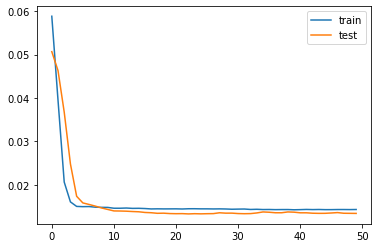

Test RMSE: 26.470


In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)